In [1]:
import igraph as ig  
import numpy as np  
import pandas as pd
import random
import warnings
import os
from multiprocessing import Pool, cpu_count, Manager
from concurrent.futures import ProcessPoolExecutor, as_completed  
import json
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import multiprocessing
from tqdm import tqdm
from itertools import product, islice
from multiprocessing import Manager

plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["figure.autolayout"] = True
font = 20

plt.rcParams['font.size'] = font
plt.rcParams.update({'font.size':font})
# Set the axes labels font size
plt.rc('axes', labelsize=font)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=font)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=font)


def save(obj, file):
    with open(file,"wb") as file:
        pickle.dump(obj,file)

def load(file):
    with open(file,"rb") as file:
        obj = pickle.load(file)

    return obj

def extract_lcc(A_nodes, net):  
    """  
    Extracts the Largest Connected Component (LCC) from a subgraph of `net` induced by the set of node names `A_nodes`.  

    Parameters:  
    ----  
    A_nodes : set  
        A set of node names.  
    net : igraph.Graph  
        The original graph.  

    Returns:  
    ----  
    igraph.Graph  
        The subgraph containing only the nodes in the largest connected component of the subgraph  
        induced by `A_nodes`.  
    """  
    net_node_names = set(net.vs["name"])  
    missing_nodes = A_nodes - net_node_names  

    if missing_nodes:  
        warnings.warn(f"The following nodes are not in the network and will be ignored: {missing_nodes}", UserWarning)  
        A_nodes = A_nodes - missing_nodes  

    if not A_nodes:  
        return net.subgraph([])  # Return an empty graph if no valid nodes are left  

    # Get vertex indices for the nodes in A_nodes  
    indices = [net.vs.find(name=name).index for name in A_nodes]  
    subgraph = net.subgraph(indices)  

    # Get connected components of the subgraph  
    components = subgraph.clusters()  
    # Get the largest connected component  
    largest_component = components.giant()  

    return largest_component   

def _degree_match_null_model(net):  
    """  
    Creates a dictionary mapping degrees to lists of node names with that degree.  

    Parameters:  
    ----  
    net : igraph.Graph  
        The input network.  

    Returns:  
    ----  
    dict :  
        A dictionary where keys are degrees and values are lists of node names with that degree.  
    """  
    degrees = net.degree()  
    node_names = net.vs["name"]  
    degree_dict = {}  
    for name, degree in zip(node_names, degrees):  
        degree_dict.setdefault(degree, []).append(name)  
    return degree_dict 

def _sample_preserving_degrees(net, A_nodes, bucket):  
    """  
    Samples nodes from the network preserving their degrees.  

    Parameters:  
    ----  
    net : igraph.Graph  
        The input network.  
    A_nodes : set  
        Original set of node names.  
    bucket : dict  
        A dictionary mapping degrees to node names.  

    Returns:  
    ----  
    set :  
        A new set of node names with the same degree distribution as A_nodes.  
    """  
    sampled_nodes = set()  
    degrees = {}  
    for name in A_nodes:  
        idx = net.vs.find(name=name).index  
        degree = net.degree(idx)  
        degrees[name] = degree  
    for name, degree in degrees.items():  
        available_nodes = set(bucket.get(degree, [])) - sampled_nodes - A_nodes  
        if not available_nodes:  
            # If no nodes available with the same degree, choose any node  
            available_nodes = set(net.vs["name"]) - sampled_nodes - A_nodes  
        if available_nodes:  
            sampled_node = random.choice(list(available_nodes))  
            sampled_nodes.add(sampled_node)  
        else:  
            # Should not occur, but handle just in case  
            sampled_nodes.add(name)  
    return sampled_nodes  


def degree_log_binning(net, bin_size):  
    """  
    Creates bins of nodes based on degree bins with a minimum size of `bin_size`.  

    Parameters:  
    ----  
    net : igraph.Graph  
        The input network.  

    bin_size : int  
        Minimum number of nodes per bin.  

    Returns:  
    ----  
    dict :  
        A dictionary mapping degrees to lists of node names in each bin.  
    """  
    degrees = net.degree()  
    nodes = net.vs["name"]  
    degree_node_pairs = sorted(zip(degrees, nodes), key=lambda x: x[0])  

    nodes_in_bins = []  
    current_bin = []  
    current_bin_size = 0  

    for degree, name in degree_node_pairs:  
        current_bin.append((degree, name))  
        current_bin_size += 1  
        if current_bin_size >= bin_size:  
            nodes_in_bins.append(current_bin)  
            current_bin = []  
            current_bin_size = 0  

    if current_bin:  
        nodes_in_bins.append(current_bin)  

    bin_dict = {}  
    for bin_nodes in nodes_in_bins:  
        bin_degrees = set([degree for degree, _ in bin_nodes])  
        bin_names = [name for _, name in bin_nodes]  
        for degree in bin_degrees:  
            bin_dict[degree] = bin_names  

    return bin_dict  


def lcc_significance(net, A, null_model='degree_match', node_bucket=None, n_iter=1000, bin_size=100):  
    """  
    Calculate the statistical significance of the size of the Largest Connected Component (LCC)  
    of a subgraph induced by the node set `A` in the network `net`.  

    Parameters:  
    ----  
    net : igraph.Graph  
        The input network.  
    A : list or set  
        The set of node names for which the LCC is to be determined.  
    null_model : str, optional (default='degree_match')  
        The method used for generating the null model. Can be 'degree_match', 'degree_log_binning',  
        'uniform', or 'custom'.  
    node_bucket : dict, optional  
        A collection of nodes to be used in 'custom' mode, mandatory when the null_model is set to 'custom'.  
    n_iter : int, optional (default=1000)  
        Number of iterations for generating the null model distribution.  
    bin_size : int, optional (default=100)  
        Size of bins if 'degree_log_binning' method is used.  

    Returns:  
    ----  
    dict :  
        A dictionary containing:  
        - 'd_mu': Mean of the null model LCC size distribution.  
        - 'd_sigma': Standard deviation of the null model LCC size distribution.  
        - 'z_score': The z-score of the observed LCC size.  
        - 'p_val': The p-value corresponding to the z-score.  
        - 'lcc': The largest connected component subgraph of `A`.  
        - 'lcc_size': Size of the largest connected component of `A`.  
        - 'dist': The null model LCC size distribution.  
    """  
    net_node_names = set(net.vs["name"])  
    sA = set(A)  
    set_a = sA & net_node_names  

    if len(sA.difference(set_a)) > 0:  
        warnings.warn("A contains elements that are not present in the network.", UserWarning)  
    if n_iter <= 0:  
        raise ValueError("n_iter must be greater than 0")  

    # Null model creation  
    if null_model == 'degree_match':  
        bucket = _degree_match_null_model(net)  
    elif null_model == 'degree_log_binning':  
        if bin_size < 1:  
            raise ValueError("bin_size must be greater or equal than 1")  
        bucket = degree_log_binning(net, bin_size)  
    elif null_model == 'uniform':  
        bucket = net_node_names - set_a  
    else:  
        raise ValueError("Null model should be in ['degree_match', 'degree_log_binning', 'uniform', 'custom']")  

    # Compute observed LCC  
    lcc_subgraph = extract_lcc(set_a, net)  
    l_lcc = lcc_subgraph.vcount()  

    distribution = []  
    for i in range(n_iter):  
        if null_model == 'uniform':  
            rs = set(random.sample(list(bucket), len(set_a)))  
        elif null_model in ['degree_match', 'degree_log_binning']:  
            rs = _sample_preserving_degrees(net, set_a, bucket)  
        elif null_model == 'custom':  
            rs = set(random.choice(bucket.get(node, [node])) for node in set_a)  
        else:  
            raise ValueError("Invalid null model specified.")  
        sub = extract_lcc(rs, net)  
        distribution.append(sub.vcount())  
        if (i + 1) % 100 == 0 or i == n_iter - 1:  
            print(f"\rIter {i + 1} of {n_iter}", end="")  
    print("")  

    mu = np.mean(distribution)  
    sigma = np.std(distribution)  
    z = (l_lcc - mu) / sigma if sigma != 0 else 0.0  
    distribution = np.array(distribution)  
    S = distribution[distribution >= l_lcc]  
    pval = len(S) / len(distribution) if len(distribution) > 0 else 1.0  
    return {  
        'd_mu': mu,  
        'd_sigma': sigma,  
        'z_score': z,  
        'p_val': pval,  
        'lcc': lcc_subgraph,  
        'lcc_size': l_lcc,  
        'dist': distribution  
    }  

In [2]:
import igraph as ig  
import numpy as np  
import warnings  
from multiprocessing import Pool, cpu_count  
import logging  
from concurrent.futures import ProcessPoolExecutor, as_completed  
import os  
import warnings  



def _split_into_chunks(lst, n):  
    """Split a list into n chunks."""  
    k, m = divmod(len(lst), n)  
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]  
    
def extract_lcc(A_nodes, net):  
    """  
    Extracts the Largest Connected Component (LCC) from a subgraph of `net` induced by the set of node names `A_nodes`.  

    Parameters  
    ----------  
    A_nodes : set  
        A set of node names.  
    net : igraph.Graph  
        The original graph.  

    Returns  
    -------  
    igraph.Graph  
        The subgraph containing only the nodes in the largest connected component of the subgraph  
        induced by `A_nodes`.  
    """  
    net_node_names = set(net.vs["name"])  
    missing_nodes = A_nodes - net_node_names  

    if missing_nodes:  
        warnings.warn(f"The following nodes are not in the network and will be ignored: {missing_nodes}", UserWarning)  
        A_nodes = A_nodes - missing_nodes  

    if not A_nodes:  
        return net.subgraph([])  # Return an empty graph if no valid nodes are left  

    # Get vertex indices for the nodes in A_nodes  
    indices = [net.vs.find(name=name).index for name in A_nodes]  
    subgraph = net.subgraph(indices)  

    # Get connected components of the subgraph  
    components = subgraph.clusters()  
    # Get the largest connected component  
    largest_component = components.giant()  

    return largest_component  


def _degree_match_null_model(net):  
    """  
    Creates a dictionary mapping degrees to lists of node names with that degree.  

    Parameters  
    ----------  
    net : igraph.Graph  
        The input network.  

    Returns  
    -------  
    dict  
        A dictionary where keys are degrees and values are lists of node names with that degree.  
    """  
    degrees = net.degree()  
    node_names = net.vs["name"]  
    degree_dict = {}  
    for name, degree in zip(node_names, degrees):  
        degree_dict.setdefault(degree, []).append(name)  
    return degree_dict  

def degree_log_binning(net, bin_size):  
    """  
    Creates bins of nodes based on degree bins with a minimum size of `bin_size`.  

    Parameters  
    ----------  
    net : igraph.Graph  
        The input network.  

    bin_size : int  
        Minimum number of nodes per bin.  

    Returns  
    -------  
    dict  
        A dictionary mapping degrees to lists of node names in each bin.  
    """  
    degrees = net.degree()  
    nodes = net.vs["name"]  
    degree_node_pairs = sorted(zip(degrees, nodes), key=lambda x: x[0])  

    nodes_in_bins = []  
    current_bin = []  
    current_bin_size = 0  

    for degree, name in degree_node_pairs:  
        current_bin.append((degree, name))  
        current_bin_size += 1  
        if current_bin_size >= bin_size:  
            nodes_in_bins.append(current_bin)  
            current_bin = []  
            current_bin_size = 0  

    if current_bin:  
        nodes_in_bins.append(current_bin)  

    bin_dict = {}  
    for bin_nodes in nodes_in_bins:  
        bin_degrees = set([degree for degree, _ in bin_nodes])  
        bin_names = [name for _, name in bin_nodes]  
        for degree in bin_degrees:  
            bin_dict[degree] = bin_names  

    return bin_dict  

def _strength_binning(net, bin_size):  
    """  
    Creates bins of nodes based on strength (sum of edge weights) with a minimum size of `bin_size`.  

    Parameters  
    ----------  
    net : igraph.Graph  
        The input network.  

    bin_size : int  
        Minimum number of nodes per bin.  

    Returns  
    -------  
    dict  
        A dictionary mapping strengths to lists of node names in each bin.  
    """  
    # Calculate the strength of each node  
    strengths = net.strength(weights="weight")  
    nodes = net.vs["name"]  
    strength_node_pairs = sorted(zip(strengths, nodes), key=lambda x: x[0], reverse=True)  

    nodes_in_bins = []  
    current_bin = []  
    current_bin_size = 0  

    for strength, name in strength_node_pairs:  
        current_bin.append((strength, name))  
        current_bin_size += 1  
        if current_bin_size >= bin_size:  
            nodes_in_bins.append(current_bin)  
            current_bin = []  
            current_bin_size = 0  

    if current_bin:  
        nodes_in_bins.append(current_bin)  

    bin_dict = {}  
    for bin_nodes in nodes_in_bins:  
        bin_strengths = set([strength for strength, _ in bin_nodes])  
        bin_names = [name for _, name in bin_nodes]  
        for strength in bin_strengths:  
            bin_dict[strength] = bin_names  

    return bin_dict  

def _sample_preserving_degrees(net, A_nodes, bucket):
    """
    Samples nodes from the network preserving their degrees.

    Parameters
    ----------
    net : igraph.Graph
        The input network.
    A_nodes : set
        Original set of node names.
    bucket : dict
        A dictionary mapping degrees to node names.

    Returns
    -------
    set
        A new set of node names with the same degree distribution as A_nodes.
    """
    sampled_nodes = set()
    degrees = {}

    for name in A_nodes:
        try:
            # Find the vertex index and calculate its degree
            vertex_index = net.vs.find(name=name).index  # Find index by name
            degree = net.degree(vertex_index)  # Use the vertex index to get degree
            degrees[name] = degree
        except ValueError:
            # Skip the node if it is not found in the graph
            print(f"Warning: Node {name} not found in the graph. Skipping...")
            continue

    for name, degree in degrees.items():
        available_nodes = set(bucket.get(degree, [])) - sampled_nodes - A_nodes
        if not available_nodes:
            # If no nodes available with the same degree, choose any node not already sampled
            available_nodes = set(net.vs["name"]) - sampled_nodes - A_nodes
        if available_nodes:
            sampled_node = random.choice(list(available_nodes))
            sampled_nodes.add(sampled_node)
        else:
            # Should not occur, but handle just in case
            sampled_nodes.add(name)

    return sampled_nodes

def _sample_node_proxy(net, S, bucket):  
    """  
    Samples nodes using a proxy (custom) method.  

    Parameters  
    ----------  
    net : igraph.Graph  
        The input network.  
    S : set  
        Original set of node names.  
    bucket : dict  
        A dictionary mapping nodes to their proxy lists.  

    Returns  
    -------  
    set  
        A new set of node names sampled from the proxies.  
    """  
    sampled_nodes = set()  

    for node in S:  
        available_nodes = bucket.get(node, [])  
        if not available_nodes:  
            available_nodes = list(set(net.vs["name"]) - sampled_nodes - S)  
        # Ensure unique sampling  
        available_nodes = list(set(available_nodes) - sampled_nodes)  
        if available_nodes:  
            chosen_node = random.choice(available_nodes)  
            sampled_nodes.add(chosen_node)  
        else:  
            sampled_nodes.add(node)  # Fallback if no proxies available  
    return sampled_nodes  

def _RWR_Matrix(G, c):  
    """  
    Calculate Random Walk with Restart (RWR) matrix.  

    Parameters  
    ----------  
    G : igraph.Graph  
        The input network.  
    c : float  
        Restart probability (typically between 0 and 1).  

    Returns  
    -------  
    tuple  
        (M, node_to_index, index_to_node)  
        M: numpy.ndarray, the RWR matrix.  
        node_to_index: dict, mapping node names to indices.  
        index_to_node: dict, mapping indices to node names.  
    """  
    node_to_index = {node: i for i, node in enumerate(G.vs["name"])}  
    index_to_node = {i: node for node, i in node_to_index.items()}  

    A = np.array(G.get_adjacency().data)  
    col_sums = A.sum(axis=0)  
    col_sums[col_sums == 0] = 1  # Avoid division by zero  
    T = A / col_sums  

    n = G.vcount()  
    I = np.eye(n)  
    M = c * np.linalg.inv(I - (1 - c) * T)  
    M = M.T  

    return (M, node_to_index, index_to_node)  

def _custom_source_distance_igraph(args):  
    """  
    Helper function for parallel custom distance computation using igraph.  

    Parameters  
    ----------  
    args : tuple  
        (source_nodes, graph, node_to_idx, custom_distance, kwargs)  

    Returns  
    -------  
    np.ndarray  
        Array containing distances.  
    """  
    source_nodes, graph, node_to_idx, custom_distance, kwargs = args  
    n_nodes = len(graph.vs)  
    mat_array = np.full((len(source_nodes), n_nodes), np.inf)  
    current_row = 0  

    for s in source_nodes:  
        try:  
            res_dict = custom_distance(s, graph, **kwargs)  
        except Exception as e:  
            warnings.warn(f"Custom distance computation failed for node {s}: {e}", UserWarning)  
            res_dict = {}  

        for target, d in res_dict.items():  
            if target in node_to_idx:  
                idx = node_to_idx[target]  
                mat_array[current_row, idx] = d  

        current_row += 1  

    # Trim unused rows if any  
    mat_array = mat_array[:current_row, :]  
    return mat_array  

def _single_shortest_path_igraph(args):  
    """Helper function for parallel shortest path computation using igraph."""  
    source_nodes, graph, node_to_idx = args  
    num_nodes = graph.vcount()  
    mat_array = np.full((len(source_nodes), num_nodes), np.inf)  
    current_row = 0  

    for s in source_nodes:  
        try:  
            source_vertex = graph.vs.find(name=s).index  
            if 'weight' in graph.edge_attributes():  
                d = graph.distances(source=source_vertex, weights='weight')[0]  
            else:  
                d = graph.distances(source=source_vertex)[0]  
            mat_array[current_row, :] = d  
            current_row += 1  
        except Exception as e:  
            warnings.warn(f"Error processing node {s}: {e}", UserWarning)  
            continue  

    # Trim unused rows  
    mat_array = mat_array[:current_row, :]  
    return mat_array  

def all_pair_distances(graph, distance="shortest_path", custom_distance=None,  
                      reset=0.2, n_processors=None, n_tasks=None, **kwargs):  
    """  
    Calculates distances between every pair of nodes in a graph according to the specified method.  

    Parameters  
    ----------  
    graph : igraph.Graph  
        The input graph.  
    distance : str, optional (default="shortest_path")  
        The distance metric to use. Options:  
        - "shortest_path"  
        - "random_walk"  
        - "biased_random_walk"  
        - "communicability"  
    custom_distance : callable, optional  
        A custom distance function to use when distance="custom".  
        It should accept a node, graph, and additional kwargs, and return a dict of target nodes and their distances.  
    reset : float, optional (default=0.2)  
        Reset probability for random walks. Only used if distance is "random_walk" or "biased_random_walk".  
    n_processors : int, optional  
        Number of processor cores to use. Defaults to the number of available CPUs.  
    n_tasks : int, optional  
        Number of parallel tasks to divide the work into.  
    **kwargs : dict  
        Additional keyword arguments for custom distance functions.  

    Returns  
    -------  
    DistanceMatrix  
        A DistanceMatrix object containing the computed distances.  
    """  
    # Parameter verification  
    if not graph.is_connected():  
        raise ValueError("The network is not connected (it contains more than one connected component)")  

    if distance not in ["shortest_path", "random_walk", "biased_random_walk", "communicability", "custom"]:  
        raise ValueError("distance must be 'shortest_path', 'random_walk', 'biased_random_walk', 'communicability', or 'custom'")  

    if distance in ["random_walk", "biased_random_walk"]:  
        if reset < 0 or reset > 1:  
            raise ValueError("Reset for random walks must comply 0 <= reset <= 1")  

    # Set up multiprocessing parameters  
    if n_processors is None:  
        n_processors = cpu_count()  

    if n_tasks is None:  
        n_tasks = n_processors  

    if n_tasks < n_processors:  
        raise ValueError("Number of tasks should be larger or equal to the number of processors.")  

    # Initialize DistanceMatrix  
    D = DistanceMatrix()  
    D._from_name_list(list(graph.vs["name"]))  

    # Process based on distance type  
    if distance == "shortest_path":  
        # Split nodes into chunks for parallel processing  
        chunks = _split_into_chunks(list(graph.vs["name"]), n_tasks)  
        args = [(chunk, graph, D.node_to_idx) for chunk in chunks]  

        # Execute parallel processing  
        with Pool(processes=n_processors) as pool:  
            spl_res = pool.map(_single_shortest_path_igraph, args)  

        # Combine results by assigning each sub_mat to the correct rows  
        res_mat = np.full((len(graph.vs), len(graph.vs)), np.inf)  
        start_row = 0  
        for sub_mat in spl_res:  
            num_rows = sub_mat.shape[0]  
            res_mat[start_row:start_row + num_rows, :] = sub_mat  
            start_row += num_rows  
        D.matrix = res_mat 

    elif distance in ["random_walk", "biased_random_walk"]:  
        M, node_to_index, index_to_node = _RWR_Matrix(graph, reset)  

        if distance == "random_walk":  
            M = np.log(M)  
            ma, mi = np.max(M), np.min(M)  
            M = 1 - ((M - mi) / (ma - mi))  
        else:  # biased_random_walk  
            degrees = np.array(graph.degree())  
            # Avoid division by zero  
            degrees[degrees == 0] = 1  
            B = M / degrees[:, None]  
            B = np.log(B)  
            ma, mi = np.max(B), np.min(B)  
            B = 1 - ((B - mi) / (ma - mi))  
            M = B  

        D.matrix = M  

    elif distance == "communicability":  
        # Communicability is typically the exponential of the adjacency matrix  
        # Here, we approximate it using matrix exponentiation  
        A = np.array(graph.get_adjacency(attribute=None).data)  
        comm = np.linalg.matrix_power(np.exp(A), 1)  # Simplified; adjust exponent as needed  
        B = np.log(comm)  
        ma, mi = np.max(B), np.min(B)  
        if ma - mi != 0:  
            B = 1 - ((B - mi) / (ma - mi))  
        else:  
            B = np.zeros_like(B)  
        D.matrix = B  

    elif distance == "custom":  
        if not callable(custom_distance):  
            raise ValueError("custom_distance must be a callable function when distance='custom'.")  

        # Split nodes into chunks for parallel processing  
        chunks = _split_into_chunks(graph.vs["name"], n_tasks)  
        args = [(chunk, graph, D.node_to_idx, custom_distance, kwargs) for chunk in chunks]  

        # Execute parallel processing  
        with Pool(processes=n_processors) as pool:  
            spl_res = pool.map(_custom_source_distance_igraph, args)  

        # Combine results  
        res_mat = np.full((len(graph.vs), len(graph.vs)), np.inf)  
        for sub_mat in spl_res:  
            res_mat = np.minimum(res_mat, sub_mat)  # Keep the smallest distances  
        D.matrix = res_mat  

    return D  

# def _calculate_score(args):  
#     """  
#     Worker function to calculate the screening score for a (source, target) pair.  
  
#     Parameters  
#     ----------  
#     args : tuple  
#         Contains all necessary arguments:  
#         source, target, sources, targets, network, distance_array,  
#         node_to_idx, score, properties, null_model, node_bucket,  
#         n_iter, bin_size, symmetric.  
  
#     Returns  
#     -------  
#     tuple  
#         (source, target, result_dict)  
#     """  
#     (  
#         source, target, sources, targets, network,  
#         distance_array, node_to_idx, score, properties, null_model,  
#         node_bucket, n_iter, bin_size, symmetric  
#     ) = args  
  
#     # Proceed with your screening logic  
#     if score == "proximity":  
#         # Replace `lcc_significance` with your actual implementation  
#         result = lcc_significance(  
#             network, sources[source], null_model=null_model,  
#             node_bucket=node_bucket, n_iter=n_iter, bin_size=bin_size,  
#             distance_matrix=distance_array, node_to_idx=node_to_idx  
#         )  
#         # Extract desired properties  
#         results = {prop: result.get(prop, None) for prop in properties}  
#     elif score == "separation":  
#         # Replace `separation` with your actual implementation  
#         separation_val = separation(  
#             network, sources[source], targets[target],  
#             distance_array, node_to_idx  
#         )  
#         results = {"raw_separation": separation_val}  
#     else:  
#         raise ValueError(f"Unsupported score type: {score}")  
  
#     return (source, target, results)  


def _check_dictionary_integrity(network, node_dict):  
    """  
    Validates and cleans a dictionary of node sets against the provided network graph.  

    Parameters  
    ----------  
    network : networkx.Graph or igraph.Graph  
        The graph to validate node existence against.  
    node_dict : dict  
        Dictionary with keys as identifiers and values as iterables of node names.  

    Returns  
    -------  
    valid_dict : dict  
        Cleaned dictionary containing only nodes present in the network.  
    """  
   
    if isinstance(network, ig.Graph):  
        graph_nodes = set(network.vs["name"])  
    else:  
        raise TypeError("Unsupported graph type. Use networkx.Graph or igraph.Graph.")  

    valid_dict = {}  
    for key, nodes in node_dict.items():  
        if not isinstance(nodes, (set, list, tuple)):  
            raise TypeError(f"Value for key '{key}' must be a set, list, or tuple.")  

        # Convert nodes to a set for efficient operations  
        nodes_set = set(nodes)  
        # Identify valid and invalid nodes  
        valid_nodes = nodes_set & graph_nodes  
        invalid_nodes = nodes_set - graph_nodes  

        if invalid_nodes:  
            warnings.warn(  
                f"The following nodes in '{key}' are not present in the network and will be ignored: {invalid_nodes}",  
                UserWarning  
            )  

        if valid_nodes:  
            valid_dict[key] = valid_nodes  
        else:  
            warnings.warn(  
                f"All nodes for '{key}' are invalid and will be excluded from the results.",  
                UserWarning  
            )  

    return valid_dict  


def plot_lcc_significance(lcc_data):

    df = lcc_data.sort_values(by="size",ascending=False)
    df = df.fillna(0)

    #plot size
    plt.figure()
    plt.bar(df['disease'], df['size'])
    plt.axhline(y=10,linestyle="--",color="grey",linewidth=2)
    plt.ylabel('LCC Size')
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them right
    plt.yscale("log")
    plt.show()

    #plot z-score
    plt.figure()
    plt.bar(df['disease'], df['zscore'])
    plt.axhline(y=2,linestyle="--",color="grey",linewidth=2)
    plt.ylabel('LCC Z-Score')
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them right
    plt.show()

    #plot p-value
    plt.figure()
    plt.bar(df['disease'], df['pval'])
    plt.axhline(y=0.05,linestyle="--",color="grey",linewidth=2)
    plt.ylabel('LCC p-value')
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them right
    plt.yscale("log")
    plt.show()


def compute_distances_chunk_with_progress(graph, nodes, progress_counter, lock):
    """Helper function to compute distances for a chunk of nodes with progress tracking."""
    distances = []
    for node in nodes:
        distances.append(graph.shortest_paths(source=node)[0])
        with lock:  # Use the explicit lock for thread safety
            progress_counter.value += 1  # Increment the progress counter
    return distances


def separation(net, A, B, D):  
    """  
    Computes the separation between two sets of nodes, A and B, in the network `net`.  

    Parameters  
    ----------  
    net : igraph.Graph  
        The input network.  
    A : set  
        First set of nodes.  
    B : set  
        Second set of nodes.  
    D : numpy.ndarray  
        Precomputed distance matrix (as a numpy array).  

    Returns  
    -------  
    float  
        The separation value between node sets A and B in the network `net`.  
    """  
    sA = set(A)  
    sB = set(B)  

    # Determine the nodes in A and B that are also in the network  
    valid_a = sA & set(net.vs["name"])  
    valid_b = sB & set(net.vs["name"])  

    if len(sA.difference(valid_a)) > 0:  
        warnings.warn("A contains elements that are not present in the network.", UserWarning)  
    if len(sB.difference(valid_b)) > 0:  
        warnings.warn("B contains elements that are not present in the network.", UserWarning)  

    # Map node names to indices
    valid_a_indices = [net.vs.find(name=node).index for node in valid_a]  
    valid_b_indices = [net.vs.find(name=node).index for node in valid_b]  

    # Compute average minimum shortest path length  
    min_distances = []  
    for i in valid_a_indices:  
        distances = [D[i, j] for j in valid_b_indices if D[i, j] != np.inf]  
        if distances:  
            min_distances.append(min(distances))  

    if not min_distances:  
        return np.inf  # If no valid distances found  

    avg_sep = np.mean(min_distances)  
    return avg_sep  

def proximity(net, T, S, D, null_model='degree_match', node_bucket=None, n_iter=1000, bin_size=100, symmetric=False):  
    """  
    Calculates the proximity between two sets of nodes T and S in the network `net`.  

    Parameters  
    ----------  
    net : igraph.Graph  
        The input network.  
    T : set  
        The set of nodes T.  
    S : set  
        The set of nodes S.  
    D : DistanceMatrix  
        Precomputed distance matrix.  
    null_model : str, optional (default='degree_match')  
        The null model to use for significance testing.  
    node_bucket : dict, optional  
        Bucket for custom null models.  
    n_iter : int, optional (default=1000)  
        Number of iterations for null model.  
    bin_size : int, optional (default=100)  
        Bin size for null model.  
    symmetric : bool, optional (default=False)  
        Whether to compute symmetrical proximity.  

    Returns  
    -------  
    dict  
        A dictionary containing proximity statistics.  
    """  
    # Call separation to compute observed separation  
    observed_sep = separation(net, T, S, D)  

    # Now, create null distribution by resampling  
    if null_model == 'degree_match':  
        bucket = _degree_match_null_model(net)  
    elif null_model == 'degree_log_binning':  
        bucket = degree_log_binning(net, bin_size)  
    elif null_model == 'uniform':  
        bucket = set(net.vs["name"]) - T - S   
    else:  
        raise ValueError("Null model should be in ['degree_match', 'degree_log_binning', 'uniform']")  

    distribution = []  
    for _ in range(n_iter):  
        if null_model in ['degree_match', 'degree_log_binning']:  
            ran_T = _sample_preserving_degrees(net, T, bucket)  
            ran_S = _sample_preserving_degrees(net, S, bucket)  
        elif null_model == 'custom':  
            ran_T = _sample_node_proxy(net, T, bucket)  
            ran_S = _sample_node_proxy(net, S, bucket)  
        elif null_model == 'uniform':  
            ran_T = set(random.sample(list(bucket), len(T)))  
            ran_S = set(random.sample(list(bucket), len(S)))  
        else:  
            raise ValueError("Invalid null model specified.")  

        ran_sep = separation(net, ran_T, ran_S, D)  
        distribution.append(ran_sep)  

    mu = np.mean(distribution)  
    sigma = np.std(distribution)  
    z = (observed_sep - mu) / sigma if sigma != 0 else 0.0  

    # Compute p-values  
    distribution = np.array(distribution)  
    tail = distribution[distribution >= observed_sep]  
    pval_single = len(tail) / len(distribution) if len(distribution) > 0 else 1.0  

    tail = np.abs(distribution)  
    tail = tail[tail >= np.abs(observed_sep)]  
    pval_double = len(tail) / len(distribution) if len(distribution) > 0 else 1.0  

    return {  
        'd_mu': mu,  
        'd_sigma': sigma,  
        'z_score': z,  
        'p_value_single_tail': pval_single,  
        'p_value_double_tail': pval_double,  
        'raw_separation': observed_sep,  
        'dist': distribution  
    }  




def process_pair(pair, sources, targets, graph, distance_matrix, score, properties, null_model, n_iter):
    source_name, target_name = pair
    source_nodes = sources[source_name]
    target_nodes = targets[target_name]

    # Compute proximity
    proximity_result = proximity(graph, source_nodes, target_nodes, distance_matrix,
                                 null_model=null_model, n_iter=n_iter)
    
    # Map results to requested properties
    results = {prop: proximity_result[prop] for prop in properties if prop in proximity_result}
    return source_name, target_name, results
 
def extract_genes_for_disease(disease_gene_dict, disease_name):
    """
    Extracts gene symbols for a specific disease.
    """
    return disease_gene_dict.get(disease_name, set())

# Function to create a filtered gene-disease dictionary
def filter_diseases(disease_gene_dict, disease_list):
    """
    Creates a new dictionary for a list of diseases with their corresponding gene symbols.
    """
    return {disease: disease_gene_dict.get(disease, set()) for disease in disease_list}

def screening_concurrent_futures_igraph(sources, targets, graph, distance_matrix, score="proximity", 
                                        properties=["z_score"], null_model="degree_log_binning", 
                                        n_iter=1000, bin_size=100, symmetric=False, 
                                        n_procs=4, batch_size=20):
    """
    Screens for relationships between sets of source and target nodes within a given igraph network.
    
    Parameters:
        - sources, targets: Dictionaries mapping names to sets of nodes in the network.
        - graph: igraph.Graph object.
        - distance_matrix: Precomputed shortest path distance matrix (numpy array).
        - score: Metric for evaluation ("proximity").
        - properties: List of properties to compute.
        - null_model: Null model for randomization ("degree_log_binning").
        - n_iter: Number of randomization iterations.
        - bin_size: Bin size for log binning.
        - symmetric: Whether to compute symmetric proximity.
        - n_procs: Number of parallel processes.
        - batch_size: Number of pairs to process per batch.
        
    Returns:
        A dictionary with results for each property as pandas DataFrames.
    """
    if score != "proximity":
        raise ValueError("Only proximity scoring is supported currently.")

    results = {prop: pd.DataFrame(index=sources.keys(), columns=targets.keys()) for prop in properties}

    def chunked_iterable(iterable, size):
        """Yield successive chunks from an iterable."""
        it = iter(iterable)
        while chunk := list(islice(it, size)):
            yield chunk

    pairs = list(product(sources.keys(), targets.keys()))
    total_pairs = len(pairs)

    with tqdm(total=total_pairs, desc="Screening source-target pairs") as pbar:
        for batch in chunked_iterable(pairs, batch_size):
            with multiprocessing.Pool(processes=n_procs) as pool:
                for source_name, target_name, proximity_result in pool.starmap(
                    process_pair, 
                    [(pair, sources, targets, graph, distance_matrix, score, properties, null_model, n_iter) for pair in batch]
                ):
                    for prop in properties:
                        if prop in proximity_result:
                            results[prop].at[source_name, target_name] = proximity_result[prop]
                    pbar.update(1)

    return results


def screening(sources, targets, graph, distance_matrix, score="proximity", properties=["z_score"],
              null_model="degree_log_binning", n_iter=1000, bin_size=100, symmetric=False,
              n_procs=4, batch_size=20):
    """
    Screening for relationships between sources and targets in the network using proximity metrics.
    """
    # Validate input parameters
    valid_sources = _check_dictionary_integrity(graph, sources)
    valid_targets = _check_dictionary_integrity(graph, targets)

    # Run screening with concurrency
    results = screening_concurrent_futures_igraph(
        sources=valid_sources,
        targets=valid_targets,
        graph=graph,
        distance_matrix=distance_matrix,
        score=score,
        properties=properties,
        null_model=null_model,
        n_iter=n_iter,
        bin_size=bin_size,
        symmetric=symmetric,
        n_procs=n_procs,
        batch_size=batch_size
    )

    return results


def plot_results(screen_data, source):


    # Extract Z-Scores and AMSPL values for the given source
    z_scores = screen_data['z_score'].loc[source]
    p_values = screen_data['p_value_double_tail'].loc[source]

    # Create a DataFrame for manipulation and sorting
    df = pd.DataFrame({
        'Disease': z_scores.index,
        'Z-Score': z_scores.values,
        'P-Value': p_values.values
    }).sort_values(by="Z-Score", ascending=True)

    # Initialize figure and dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:blue'
    ax1.set_xlabel('Disease', fontsize=12)
    ax1.set_ylabel('Z-Score', color=color, fontsize=12)
    ax1.plot(df['Disease'], df['Z-Score'], marker='o', linestyle='-', color=color, label="Z-Score")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', labelsize=10)
    plt.xticks(rotation=45, ha='right')

    # Add second Y-axis for P-Values
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('P-Value (double-Tail)', color=color, fontsize=12)
    ax2.bar(df['Disease'], df['P-Value'], alpha=0.6, color=color, label="P-Value")
    ax2.tick_params(axis='y', labelcolor=color)

    # Add titles and grid
    plt.title(f"Z-Score and P-Values for {source}", fontsize=14)
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Legend
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000


C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000


C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000
Iter 100 of 10000

C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000
Iter 100 of 10000

C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000


C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000
Iter 200 of 10000

C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000


C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000


C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000
Iter 100 of 10000

C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_29360\3399561700.py:72: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = subgraph.clusters()


Iter 10000 of 10000


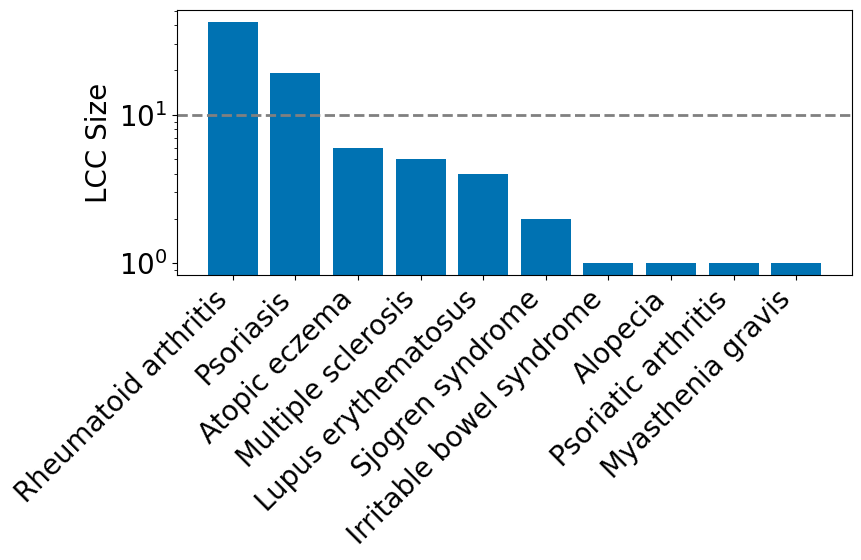

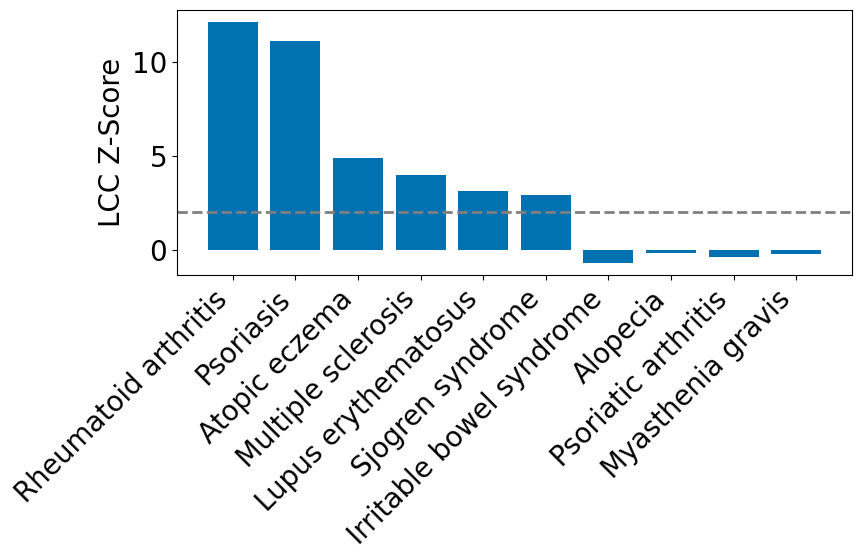

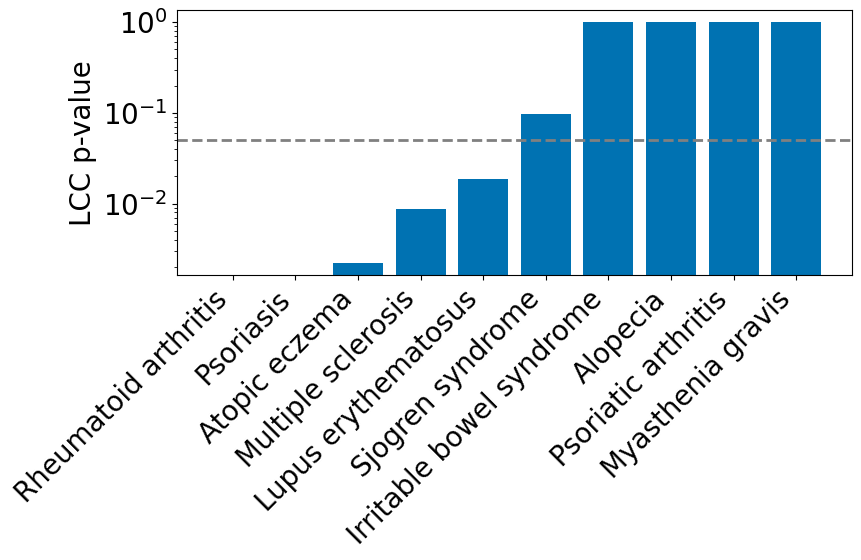

In [ ]:


#Load PPI network
ppi_ig = load("data/ppi_igraph.pkl")

with open('data/TTD_Target_Disease.json', "r") as file:

    disease_gene_dict_serializable = json.load(file)


specific_disease = "Psoriasis"
disease_list = ["Rheumatoid arthritis", "Psoriasis","Multiple sclerosis","Irritable bowel syndrome", "Lupus erythematosus",
                "Alopecia","Psoriatic arthritis","Atopic eczema","Sjogren syndrome","Multiple sclerosis","Myasthenia gravis"]

# Convert JSON-loaded values back to sets
disease_gene_dict = {
    disease: set(genes) for disease, genes in disease_gene_dict_serializable.items()
}

# Extract genes for "Psoriasis"
targets = extract_genes_for_disease(disease_gene_dict, specific_disease)
targets = set(targets) & set(ppi_ig.vs["name"])

# Create a filtered dictionary for a list of diseases
disease_genes = filter_diseases(disease_gene_dict, disease_list)



for d,g in disease_genes.items():
    disease_genes[d] = set(g) & set(ppi_ig.vs["name"])

    
lcc_size = pd.DataFrame(columns = ["disease","size","zscore","pval"])

for d,genes in disease_genes.items():
    data = lcc_significance(ppi_ig, genes,
                                      null_model="degree_match",n_iter=10000)

    new_line = [d,data["lcc_size"],data["z_score"],data["p_val"]]
    lcc_size.loc[len(lcc_size.index)] = new_line

plot_lcc_significance(lcc_size)    

In [9]:
import warnings  

# Suppress all DeprecationWarnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)  

sp_distance = all_pair_distances(ppi_ig, distance="shortest_path", n_processors=8, n_tasks=1000)
mat = sp_distance.get_matrix()


In [20]:
psoriasis = {"Psoriasis":targets}
disease_list = ["Rheumatoid arthritis","Multiple sclerosis","Irritable bowel syndrome", "Lupus erythematosus",
                "Alopecia","Psoriatic arthritis","Atopic eczema","Sjogren syndrome","Multiple sclerosis","Myasthenia gravis"]

disease_gene_dict = {
    disease: set(genes) for disease, genes in disease_gene_dict_serializable.items()
}

# Extract genes for "Psoriasis"
# targets = extract_genes_for_disease(disease_gene_dict, specific_disease)
# targets = set(targets) & set(ppi_ig.vs["name"])

# Create a filtered dictionary for a list of diseases
disease_genes = filter_diseases(disease_gene_dict, disease_list)

results = screening(
    sources=psoriasis,
    targets=disease_genes,
    graph=ppi_ig,
    distance_matrix=mat,
    score="proximity",
    properties=["z_score", "p_value_double_tail"],
    null_model="degree_log_binning",
    n_iter=5000,
    n_procs=24,
    batch_size=100
)

#print(screen_data)


/tmp/ipykernel_3176083/1731514800.py:579: UserWarning: The following nodes in 'Rheumatoid arthritis' are not present in the network and will be ignored: {'NIE', 'COX-1', 'Bact PBP', 'ALOX', 'MMP-9', 'VLA-1', 'H1R', 'p38', 'CA-I', 'ATK', 'IL1', 'NKG2A', 'NOX', 'JAK-1', 'IKK', 'GCR mRNA', 'p38 alpha', 'TWEAK', 'IL23', 'ITGAV/B3', 'IKKB', 'SAHase', 'CADM', 'PMNAC', 'MMP', 'MMP-3', 'SLC6A14', 'PTK', 'IRAK-4', 'Malaria DHOdehase', 'PD-1', 'RORG', 'IL17', 'MMP-8', 'COX-2', 'ERK2', 'CD20', 'NFKB', 'ATP2A', 'TNFA/IL1B produ', 'CRF', 'CTLA-4', 'IC', 'PRO', 'TNF mRNA', 'NE', 'JAK-3', 'p38 beta', 'CA-II', 'nAChR', 'FUN1', 'ALOX5 mRNA', 'H4R', 'FCR', 'TLR', 'BACE', '5HT2R', 'HIV tat', 'CO5', 'ODF', 'APRIL', 'MMP-1', 'COX', 'S1PR', 'KC', 'HSPB1 mRNA', 'NR', 'IgE', 'MMP-13', 'ITGA4/B7', 'IL17R', 'CHR', 'CDH11', 'SLC36A2', 'CSF-1R', 'HDAC', 'NFKB-p38 pathway', 'JAK-2', 'sPLA2', 'GM-CSF', '5-LOX', 'CB2', 'ITGA4/B1', 'TNF-R1', 'CAMK2'}
  warnings.warn(
/tmp/ipykernel_3176083/1731514800.py:579: UserWarn

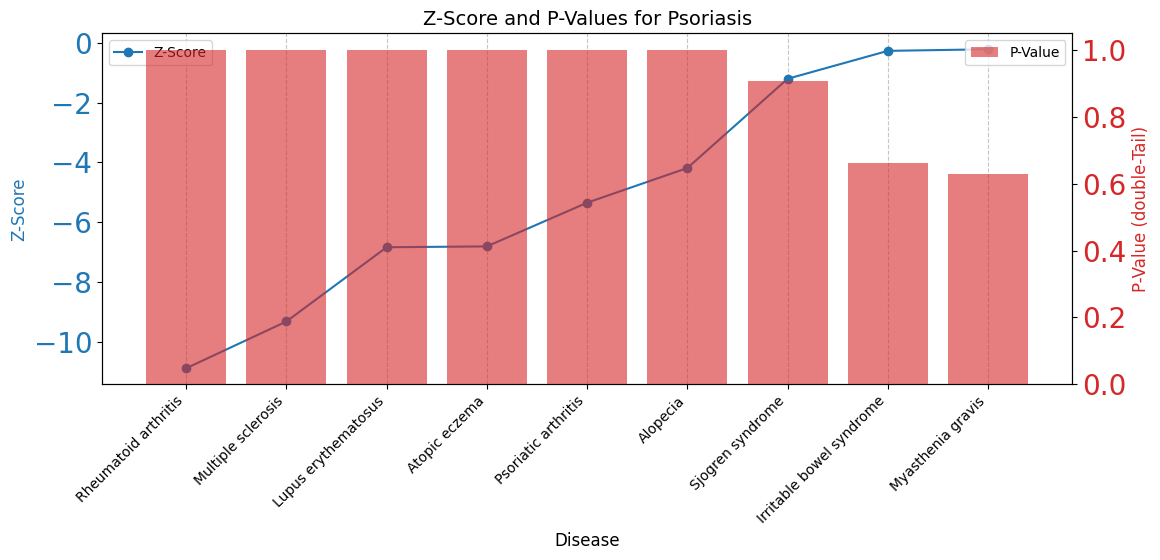

In [27]:
import pandas as pd
import matplotlib.pyplot as plt    
plot_results(results,"Psoriasis")    
